In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
import tensorflow.keras.layers as tkl

sys.path.append('../')
from medl.models.random_effects2 import RandomEffects
from spirals import make_spiral_random_radius_confounder, plot_clusters, plot_clusters_feature_hist, make_spiral_true_boundary

sns.set_style('whitegrid')

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = InteractiveSession(config=config)

tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
np.random.seed(1267)
arrX, arrZ, arrY, arrRadii, arrRatio = make_spiral_random_radius_confounder(10, 
                                                                            radius_sd=0.0, 
                                                                            ratio_sd=0.5,
                                                                            degrees=360, 
                                                                            noise=0.2,
                                                                            confounders=2)


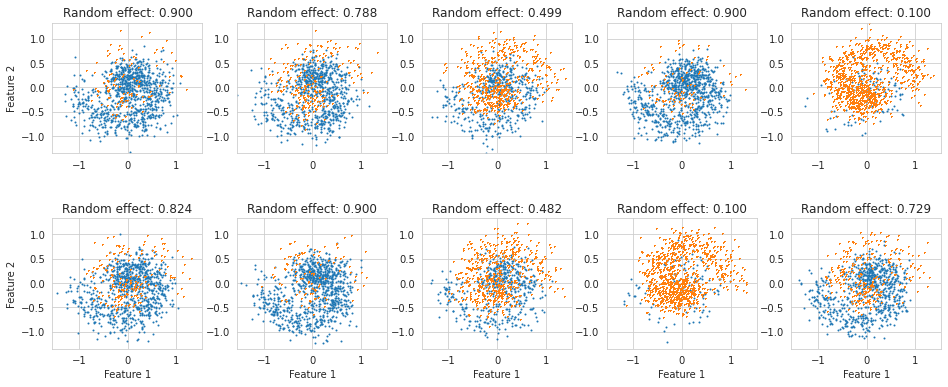

In [4]:
fig, ax = plot_clusters(arrX, arrZ, arrY, arrRatio)
plt.show()

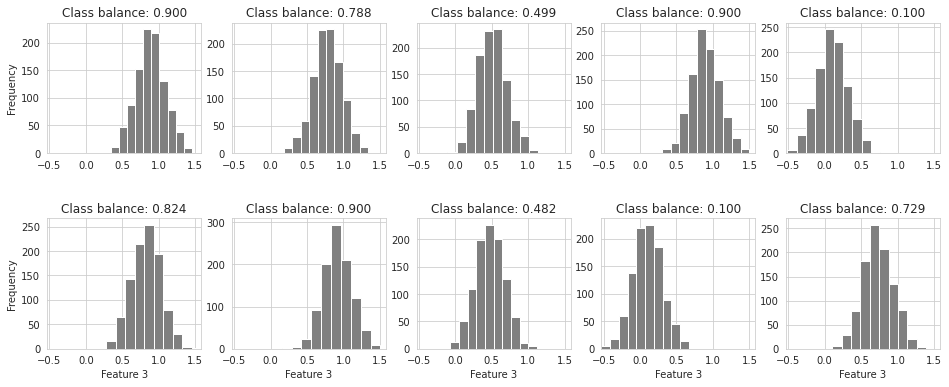

In [5]:
fig, ax = plot_clusters_feature_hist(arrX, arrZ, arrY, 2, arrRatio)
plt.show()

In [6]:
def balanced_accuracy(y_true, y_pred):
    predpos = tf.cast((y_pred >= 0.5), tf.float32)
    truepos = tf.reduce_sum(y_true * predpos, axis=0)
    tot = tf.reduce_sum(y_true, axis=0)
    recall = truepos / (tot + 1e-7)
    return tf.reduce_mean(recall)

In [7]:
def base_model():
    tInput = tkl.Input(arrX.shape[1])
    tDense1 = tkl.Dense(4, activation='relu')(tInput)
    tDense2 = tkl.Dense(4, activation='relu')(tDense1)
    tDense3 = tkl.Dense(4, activation='relu')(tDense2)
    tOutput = tkl.Dense(2, activation='softmax')(tDense3)
    
    model = tf.keras.Model(tInput, tOutput)
    model.compile(loss='categorical_crossentropy',
                  metrics=[balanced_accuracy, tf.keras.metrics.AUC(curve='PR', name='auprc')],
                  optimizer=tf.keras.optimizers.Adam())
    
    return model

def concat_model(batches):
    tInput = tkl.Input(arrX.shape[1])
    tInputZ = tkl.Input(batches)
    
    tConcat = tkl.Concatenate(axis=-1)([tInput, tInputZ])
    
    tDense1 = tkl.Dense(4, activation='relu')(tConcat)
    tDense2 = tkl.Dense(4, activation='relu')(tDense1)
    tDense3 = tkl.Dense(4, activation='relu')(tDense2)
    tOutput = tkl.Dense(2, activation='softmax')(tDense3)
    
    model = tf.keras.Model((tInput, tInputZ), tOutput)
    model.compile(loss='categorical_crossentropy',
                  metrics=[balanced_accuracy, tf.keras.metrics.AUC(curve='PR', name='auprc')],
                  optimizer=tf.keras.optimizers.Adam())
    
    return model

def me_model(batches):
    tInput = tkl.Input(arrX.shape[1])
    tInputZ = tkl.Input(batches)
    
    tRE = RandomEffects(arrX.shape[1], post_loc_init_scale=0, post_scale_init_min=0.1, 
                        post_scale_init_range=0.1, kl_weight=1/8000, 
                        l1_weight=0.001,
                        prior_scale=0.5,
                        name='re_slope')(tInputZ)
    # tConcat = tkl.Concatenate(axis=-1)([tInput, tRE * tInput])
    
    tDense1 = tkl.Dense(4, activation='relu')(tInput)
    tDense2 = tkl.Dense(4, activation='relu')(tDense1)
    tDense3 = tkl.Dense(4, activation='relu')(tDense2)
    
    tDenseRE = tkl.Dense(4, activation='relu')(tRE * tInput)
    tDenseRE2 = tkl.Dense(4, activation='relu')(tDenseRE)
    tConcat = tkl.Concatenate(axis=-1)([tDense3, tDenseRE2])
    tDenseMixed = tkl.Dense(4, activation='relu')(tConcat)
    tOutput = tkl.Dense(2, activation='softmax')(tDenseMixed)
           
    model = tf.keras.Model((tInput, tInputZ), tOutput)
    model.compile(loss='categorical_crossentropy',
                  metrics=[balanced_accuracy, tf.keras.metrics.AUC(curve='PR', name='auprc')],
                  optimizer=tf.keras.optimizers.Adam())
    
    return model

In [8]:
def crossvalidate(model_fn, z_input=False):
    dfResults = pd.DataFrame(index=range(arrZ.shape[1]), columns=['Train', 'Test', 'Held-out group'])
    for iBatch in range(arrZ.shape[1]):
        arrXSeen = arrX[arrZ[:, iBatch] == 0, :]
        arrYSeen = arrY[arrZ[:, iBatch] == 0]
        arrZSeen = arrZ[arrZ[:, iBatch] == 0, :]
        arrZSeen = np.concatenate([arrZSeen[:, :iBatch], arrZSeen[:, (iBatch+1):]], axis=1)
        
        arrXUnseen = arrX[arrZ[:, iBatch] == 1, :]
        arrYUnseen = arrY[arrZ[:, iBatch] == 1]
        arrZUnseen = np.zeros((arrXUnseen.shape[0], arrZSeen.shape[1]))
        
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
        # Stratify split by batch membership and class
        arrStrat = np.array([str(y) + str(np.where(z)[0]) for y, z in zip(arrYSeen, arrZSeen)])
        
        arrTrainIdx, arrTestIdx = next(splitter.split(arrXSeen, arrStrat))
        arrXSeenTrain = arrXSeen[arrTrainIdx]
        arrYSeenTrain = arrYSeen[arrTrainIdx]
        arrZSeenTrain = arrZSeen[arrTrainIdx]
        arrXSeenTest = arrXSeen[arrTestIdx]
        arrYSeenTest = arrYSeen[arrTestIdx]
        arrZSeenTest = arrZSeen[arrTestIdx]
        
        tf.random.set_seed(89)
        if z_input:
            model = model_fn(arrZSeen.shape[1])
            inputsTrain = (arrXSeenTrain, arrZSeenTrain)
            inputsTest = (arrXSeenTest, arrZSeenTest)
            inputsUnseen = (arrXUnseen, arrZUnseen)
        else:
            model = model_fn()
            inputsTrain = arrXSeenTrain
            inputsTest = arrXSeenTest
            inputsUnseen = arrXUnseen
            
        model.fit(inputsTrain, arrYSeenTrain, batch_size=32, epochs=100, verbose=0)
        dfResults['Train'].loc[iBatch] = model.evaluate(inputsTrain, arrYSeenTrain, verbose=0)[1]
        dfResults['Test'].loc[iBatch] = model.evaluate(inputsTest, arrYSeenTest, verbose=0)[1]       
        dfResults['Held-out group'].loc[iBatch] = model.evaluate(inputsUnseen, arrYUnseen, verbose=0)[1]       
                        
    return dfResults

In [9]:
dfPlain = crossvalidate(base_model)
print(dfPlain.mean())
print(dfPlain.std())

Train             0.810041
Test              0.807132
Held-out group    0.415686
dtype: float64
Train             0.014558
Test              0.015396
Held-out group    0.055209
dtype: float64


In [10]:
dfConcat = crossvalidate(concat_model, z_input=True)
print(dfConcat.mean())
print(dfConcat.std())

Train             0.811912
Test              0.811801
Held-out group    0.350278
dtype: float64
Train             0.031025
Test              0.031719
Held-out group    0.053179
dtype: float64


In [11]:
dfME = crossvalidate(me_model, z_input=True)
print(dfME.mean())
print(dfME.std())

Train             0.824530
Test              0.820989
Held-out group    0.431114
dtype: float64
Train             0.013575
Test              0.019588
Held-out group    0.030103
dtype: float64


In [12]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
# Stratify split by batch membership and class
arrStrat = np.array([str(y) + str(np.where(z)[0]) for y, z in zip(arrY, arrZ)])

arrTrainIdx, arrTestIdx = next(splitter.split(arrX, arrStrat))
arrXTrain = arrX[arrTrainIdx]
arrYTrain = arrY[arrTrainIdx]
arrZTrain = arrZ[arrTrainIdx]
arrXTest = arrX[arrTestIdx]
arrYTest = arrY[arrTestIdx]
arrZTest = arrZ[arrTestIdx]

In [13]:
from scipy.ndimage.filters import gaussian_filter

def plot_decision_boundary(model, X, Y, Z=None, ax=None, vmax=2):       
    arrGridX1, arrGridX2 = np.mgrid[-vmax:vmax+0.1:0.1, -vmax:vmax+0.1:0.1]
    # Fill in confounding features with the cluster mean   
    # arrGridX3 = np.ones_like(arrGridX1) * X[:, 2].mean()
    arrGridX3 = np.ones_like(arrGridX1) * 0.5
    arrGridXConf = np.stack([arrGridX3.flatten()] * (X.shape[1] - 2), axis=-1)
    arrGridX = np.concatenate([arrGridX1.reshape(-1, 1), arrGridX2.reshape(-1, 1), arrGridXConf], axis=1)
    
    if Z is not None:
        arrGridZ = np.zeros((arrGridX.shape[0], Z.shape[1]))
        arrGridZ[:, Z.sum(axis=0).argmax()] = 1
        arrGridYFlat = model.predict((arrGridX, arrGridZ), verbose=0)
    else:
        arrGridYFlat = model.predict(arrGridX, verbose=0) 

    arrGridY = (arrGridYFlat[:, 1] >= 0.5).reshape(arrGridX1.shape).astype(int)
    # arrGridY = gaussian_filter(arrGridY, 0.25)
    
    if ax is None:
        ax = plt.gca()
        
    ax.contour(arrGridX1, arrGridX2, arrGridY, levels=1, colors='k')  
    ax.contourf(arrGridX1, arrGridX2, arrGridY, levels=1, colors=['C0', 'C1'], alpha=0.5)    
    ax.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c='C0', s=5, alpha=0.9)
    ax.scatter(X[Y[:, 1] == 1, 0], X[Y[:, 1] == 1, 1], c='C1', s=10, alpha=0.9, marker='P')
        
    return fig, ax

In [14]:
def pfi(model, X, Y, Z=None, feature=2):
    arrImportance = np.zeros(100)
    if Z is not None:
        Z0 = np.zeros_like(Z)
        accBase = model.evaluate((X, Z), Y, verbose=0)[1]
    else:
        accBase = model.evaluate(X, Y, verbose=0)[1]
        
    X2 = X.copy()
    arrIdx = np.arange(X2.shape[0])
    
    for i in range(100):
        np.random.shuffle(arrIdx)
        
        X2[:, feature] = X2[arrIdx, feature]
    
        if Z is not None:
            arrImportance[i] = accBase - model.evaluate((X2, Z0), Y, verbose=0)[1]
        else:
            arrImportance[i] = accBase - model.evaluate(X2, Y, verbose=0)[1]
            
    arrImportance /= accBase
            
    return arrImportance

250/250 [==============================] - 1s 2ms/step - loss: 0.4129 - balanced_accuracy: 0.7977 - auprc: 0.8868


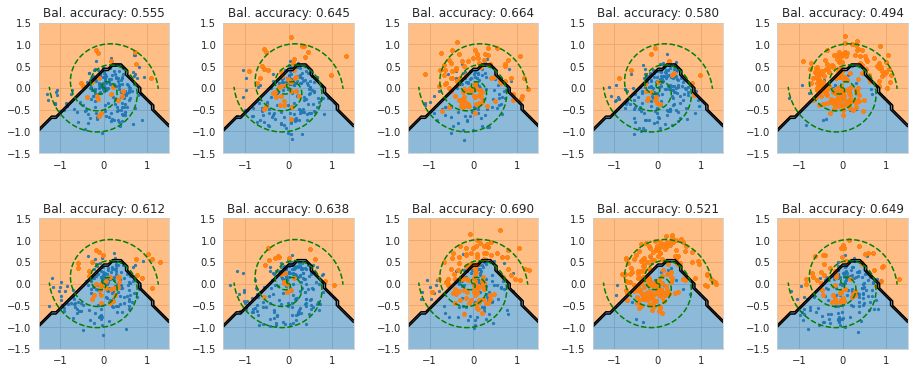

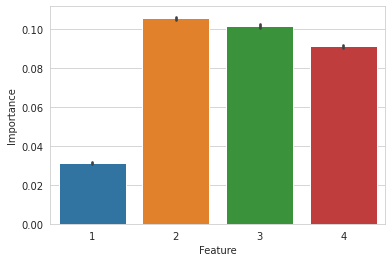

In [15]:
tf.random.set_seed(82)
modelBase = base_model()
modelBase.fit(arrXTrain, arrYTrain, batch_size=32, epochs=100, verbose=0)
modelBase.evaluate(arrXTrain, arrYTrain)

fig, ax = plt.subplots(2, 5, figsize=(16, 6), gridspec_kw={'hspace': 0.5})
vmax = 1.5
for iCluster in range(arrZTest.shape[1]):
    arrXCluster = arrXTest[arrZTest[:, iCluster]==1, :]
    arrYCluster = arrYTest[arrZTest[:, iCluster]==1, :]
    plot_decision_boundary(modelBase, arrXCluster, arrYCluster,
                            ax=ax.flatten()[iCluster],
                            vmax=vmax)
    arrTrueBoundary = make_spiral_true_boundary(classes=2, degrees=360, radius=arrRadii[iCluster])
    ax.flatten()[iCluster].plot(arrTrueBoundary[:1000, 0], arrTrueBoundary[:1000, 1], c='g', ls='--')
    ax.flatten()[iCluster].plot(arrTrueBoundary[1000:, 0], arrTrueBoundary[1000:, 1], c='g', ls='--')
    
    ax.flatten()[iCluster].set_xlim(-vmax, vmax)
    ax.flatten()[iCluster].set_ylim(-vmax, vmax)
    ax.flatten()[iCluster].set_aspect('equal')
    
    acc = modelBase.evaluate(arrXCluster, arrYCluster, verbose=0)[1]
    ax.flatten()[iCluster].set_title(f'Bal. accuracy: {acc:.03f}')

fig.show()

nFeatures = arrXTrain.shape[1]
arrPFIBase = np.zeros((100, nFeatures))
for iFeature in range(nFeatures):
    arrPFIBase[:, iFeature] = pfi(modelBase, arrXTrain, arrYTrain, feature=iFeature)

fig2, ax2 = plt.subplots()
dfImportanceBase = pd.concat([pd.DataFrame({'Feature': iFeature+1, 'Importance': arrPFIBase[:, iFeature]}) for iFeature in range(nFeatures)], axis=0)
sns.barplot(data=dfImportanceBase, x='Feature', y='Importance', ax=ax2)

fig.savefig('/home2/s169685/Downloads/base_confounded.svg', dpi=600)

del modelBase

63/63 [==============================] - 0s 3ms/step - loss: 0.3945 - balanced_accuracy: 0.8098 - auprc: 0.8947


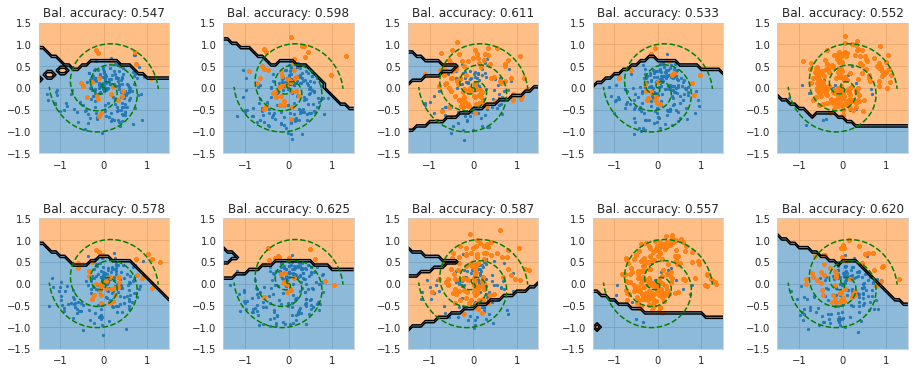

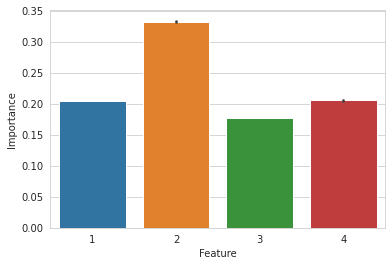

In [16]:
tf.random.set_seed(82)
modelConcat = concat_model(10)
modelConcat.fit((arrXTrain, arrZTrain), arrYTrain, batch_size=32, epochs=100, verbose=0)
modelConcat.evaluate((arrXTest, arrZTest), arrYTest)

fig, ax = plt.subplots(2, 5, figsize=(16, 6), gridspec_kw={'hspace': 0.5})
vmax = 1.5
for iCluster in range(arrZTest.shape[1]):
    arrXCluster = arrXTest[arrZTest[:, iCluster]==1, :]
    arrYCluster = arrYTest[arrZTest[:, iCluster]==1, :]
    arrZCluster = arrZTest[arrZTest[:, iCluster]==1, :]
    plot_decision_boundary(modelConcat, arrXCluster, arrYCluster, arrZCluster,
                            ax=ax.flatten()[iCluster],
                            vmax=vmax)
    arrTrueBoundary = make_spiral_true_boundary(classes=2, degrees=360, radius=arrRadii[iCluster])
    ax.flatten()[iCluster].plot(arrTrueBoundary[:1000, 0], arrTrueBoundary[:1000, 1], c='g', ls='--')
    ax.flatten()[iCluster].plot(arrTrueBoundary[1000:, 0], arrTrueBoundary[1000:, 1], c='g', ls='--')
    
    ax.flatten()[iCluster].set_xlim(-vmax, vmax)
    ax.flatten()[iCluster].set_ylim(-vmax, vmax)
    ax.flatten()[iCluster].set_aspect('equal')
    
    acc = modelConcat.evaluate((arrXCluster, arrZCluster), arrYCluster, verbose=0)[1]
    ax.flatten()[iCluster].set_title(f'Bal. accuracy: {acc:.03f}')

fig.show()

nFeatures = arrXTrain.shape[1]
arrPFIConcat = np.zeros((100, nFeatures))
for iFeature in range(nFeatures):
    arrPFIConcat[:, iFeature] = pfi(modelConcat, arrXTrain, arrYTrain, arrZTrain, feature=iFeature)

fig2, ax2 = plt.subplots()
dfImportanceConcat = pd.concat([pd.DataFrame({'Feature': iFeature+1, 'Importance': arrPFIConcat[:, iFeature]}) for iFeature in range(nFeatures)], axis=0)
sns.barplot(data=dfImportanceConcat, x='Feature', y='Importance', ax=ax2)

fig.savefig('/home2/s169685/Downloads/concat_confounded.svg', dpi=600)

del modelConcat

63/63 [==============================] - 0s 3ms/step - loss: -0.0354 - balanced_accuracy: 0.8132 - auprc: 0.9126


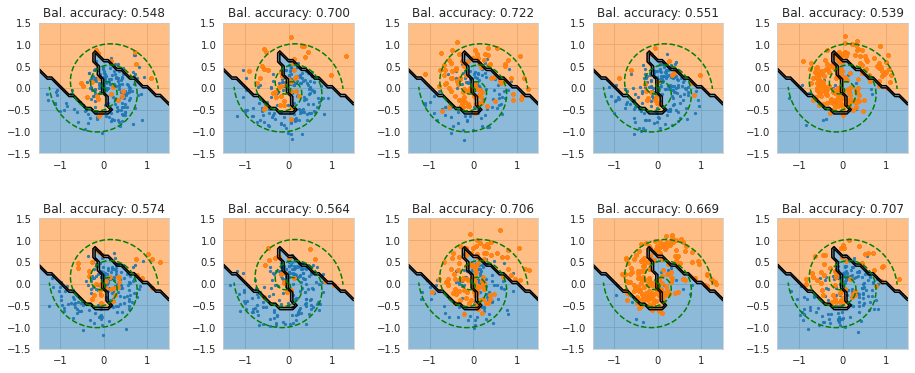

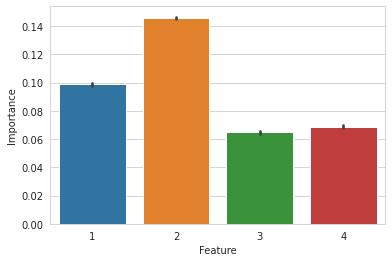

In [17]:
tf.random.set_seed(82)
modelME = me_model(10)
modelME.fit((arrXTrain, arrZTrain), arrYTrain, batch_size=32, epochs=100, verbose=0)
modelME.evaluate((arrXTest, arrZTest), arrYTest)

fig, ax = plt.subplots(2, 5, figsize=(16, 6), gridspec_kw={'hspace': 0.5})
vmax = 1.5
for iCluster in range(arrZTest.shape[1]):
    arrXCluster = arrXTest[arrZTest[:, iCluster]==1, :]
    arrYCluster = arrYTest[arrZTest[:, iCluster]==1, :]
    arrZCluster = arrZTest[arrZTest[:, iCluster]==1, :]
    plot_decision_boundary(modelME, arrXCluster, arrYCluster, arrZCluster,
                            ax=ax.flatten()[iCluster],
                            vmax=vmax)
    arrTrueBoundary = make_spiral_true_boundary(classes=2, degrees=360, radius=arrRadii[iCluster])
    ax.flatten()[iCluster].plot(arrTrueBoundary[:1000, 0], arrTrueBoundary[:1000, 1], c='g', ls='--')
    ax.flatten()[iCluster].plot(arrTrueBoundary[1000:, 0], arrTrueBoundary[1000:, 1], c='g', ls='--')
    
    ax.flatten()[iCluster].set_xlim(-vmax, vmax)
    ax.flatten()[iCluster].set_ylim(-vmax, vmax)
    ax.flatten()[iCluster].set_aspect('equal')
    
    acc = modelME.evaluate((arrXCluster, arrZCluster), arrYCluster, verbose=0)[1]
    ax.flatten()[iCluster].set_title(f'Bal. accuracy: {acc:.03f}')
    
fig.show()

nFeatures = arrXTrain.shape[1]
arrPFIME = np.zeros((100, nFeatures))
for iFeature in range(nFeatures):
    arrPFIME[:, iFeature] = pfi(modelME, arrXTrain, arrYTrain, arrZTrain, feature=iFeature)

fig2, ax2 = plt.subplots()
dfImportanceME = pd.concat([pd.DataFrame({'Feature': iFeature+1, 'Importance': arrPFIME[:, iFeature]}) for iFeature in range(nFeatures)], axis=0)
sns.barplot(data=dfImportanceME, x='Feature', y='Importance', ax=ax2)

fig.savefig('/home2/s169685/Downloads/me_confounded.svg', dpi=600)

del modelME

Compare feature importance across the models

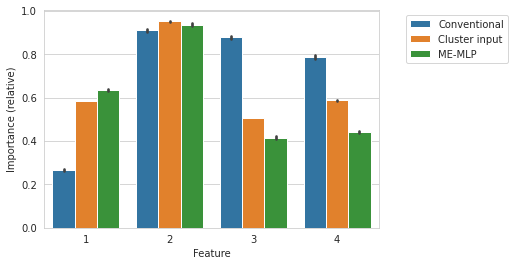

In [18]:
dfImportanceBaseZ = dfImportanceBase.copy()
dfImportanceBaseZ['Model'] = 'Conventional'
dfImportanceBaseZ['Importance'] /= dfImportanceBaseZ['Importance'].max()

dfImportanceConcatZ = dfImportanceConcat.copy()
dfImportanceConcatZ['Model'] = 'Cluster input'
dfImportanceConcatZ['Importance'] /= dfImportanceConcatZ['Importance'].max()

dfImportanceMEZ = dfImportanceME.copy()
dfImportanceMEZ['Model'] = 'ME-MLP'
dfImportanceMEZ['Importance'] /= dfImportanceMEZ['Importance'].max()

dfImportance = pd.concat([dfImportanceBaseZ, dfImportanceConcatZ, dfImportanceMEZ], axis=0)
sns.barplot(data=dfImportance, x='Feature', y='Importance', hue='Model')
plt.ylabel('Importance (relative)')
plt.legend(bbox_to_anchor=(1.4, 1))

(0.72, 0.83)

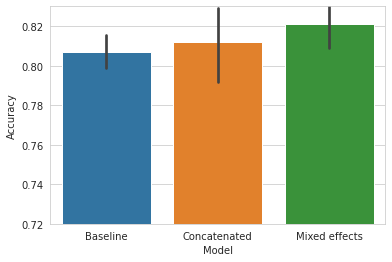

In [19]:
dfPlainLong = pd.melt(dfPlain, var_name='Partition', value_name='Accuracy')
dfPlainLong['Model'] = 'Baseline'
dfConcatLong = pd.melt(dfConcat, var_name='Partition', value_name='Accuracy')
dfConcatLong['Model'] = 'Concatenated'
dfMELong = pd.melt(dfME, var_name='Partition', value_name='Accuracy')
dfMELong['Model'] = 'Mixed effects'

dfAll = pd.concat([dfPlainLong, dfConcatLong, dfMELong], axis=0)

sns.barplot(data=dfAll.loc[dfAll['Partition'] == 'Test'], x='Model', y='Accuracy')
plt.gca().set_ylim(0.72, 0.83)

(0.28, 0.45)

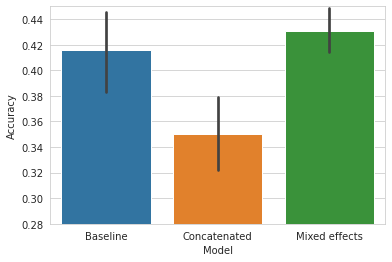

In [20]:
sns.barplot(data=dfAll.loc[dfAll['Partition'] == 'Held-out group'], x='Model', y='Accuracy')
plt.gca().set_ylim(0.28, 0.45)

In [21]:
scipy.stats.ttest_rel(dfPlain['Test'], dfME['Test'])

Ttest_relResult(statistic=-2.9736198613576628, pvalue=0.015610412625209341)

In [1]:
scipy.stats.ttest_rel(dfPlain['Held-out group'], dfME['Held-out group'])

NameError: name 'scipy' is not defined